# Bitcoin Data Analysis

## Time Series Forcasting

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss

## Overview

we are doing predictions for Bitcoin's future price, we are performing a 30-day forecasting period for the bitcoins price based on the past year's price fluctuations. each time that this file loads it will automatically download the latest Bitcoin data from Yahoo financial API which we can easily access with "yfinance" package in python. keeping that in mind that based on the changes in the Bitcoin price our models may or may not need parameter adjustments to get the most accurate results.

In [5]:
# KPSS test Function from statsmodels package
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

We begin with importing the data from Yahoo Finance and plotting the price of Bitcoin in the past year which started at around 21000 and now it is about 26000 with a gradual increase over the year. the data is not seasonal but it looks very cyclical and there is a trend.

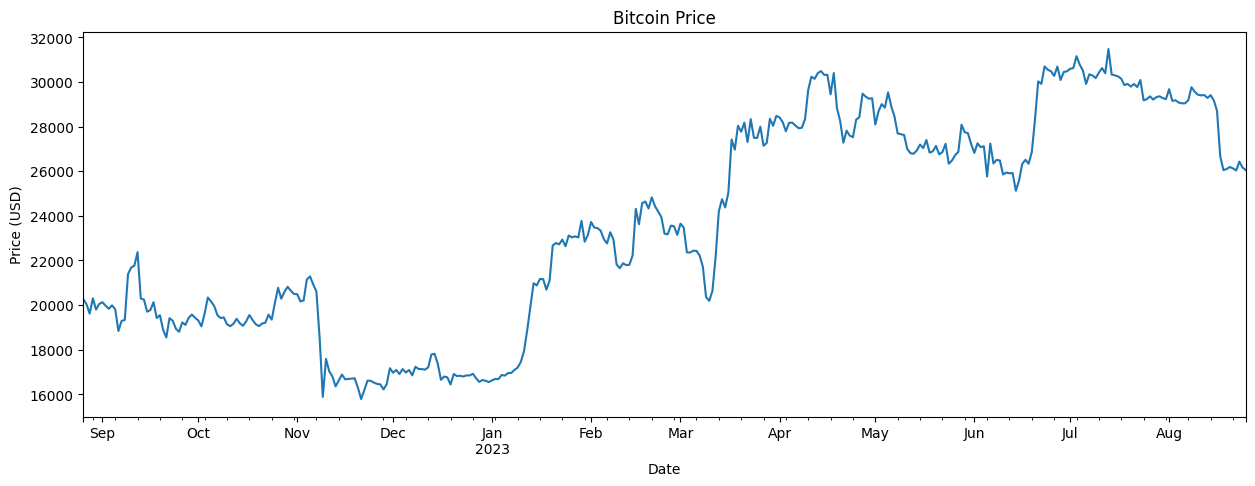

In [6]:
from datetime import timedelta

bitcoin_data = yf.download('BTC-USD',
                           start=datetime.now()- timedelta(days=365),
                           end=datetime.now(),
                           progress=False)
bitcoin_data.reset_index(inplace=True)

bitcoin_data = bitcoin_data[['Date', 'Close']]
bitcoin_data.columns = ['Date', 'Price']
bitcoin_data.set_index('Date', inplace=True)

bitcoin_data['Price'].plot(figsize=(15, 5))
plt.title('Bitcoin Price')
plt.ylabel('Price (USD)')
plt.show()

## ARIMA Model



to check the data for cyclicality and the trend, we plot ACF and PACF  to analyze our data visually we can see that the ACF plot shows that the data is highly cyclical as we assumed earlier. Hence it means that we need to do differencing on our data to make it stationary for building an ARIMA model.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


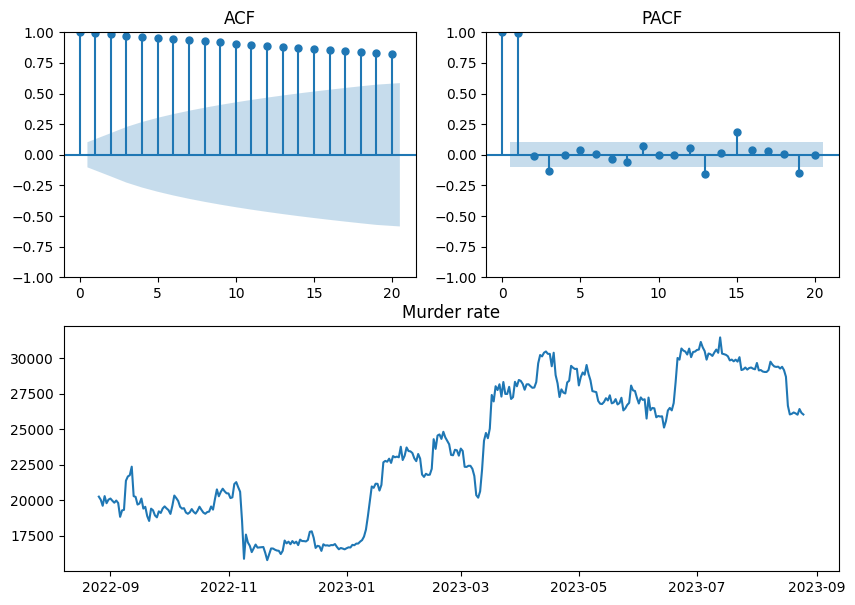

In [7]:
plt.figure(figsize=(10,7))
ax1 = plt.subplot(212)
ax1.plot(bitcoin_data)
ax1.set_title('Murder rate')
ax2 = plt.subplot(221)
ax2=plot_acf(bitcoin_data, lags=20, ax=plt.gca(), title='ACF')
ax3 = plt.subplot(222)
ax3=plot_pacf(bitcoin_data, lags=20, ax=plt.gca(), title='PACF')

we can say by looking at the data that data is not stationary but we run the KPSS test to see for sure that the test statistic is higher than critical value which we reject the $H_0$.

In [8]:
kpss_test(bitcoin_data)

Results of KPSS Test:
Test Statistic            2.563279
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


so the measure we take next is to take differencing of our current data to make it stationary for the ARIMA model. and the we plot ACF and PACF to see the correlations between lags. and we can see the data is stationary and there is no correlation between the variables. 

In [9]:
bitcoin_data_diff=bitcoin_data.diff().dropna()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


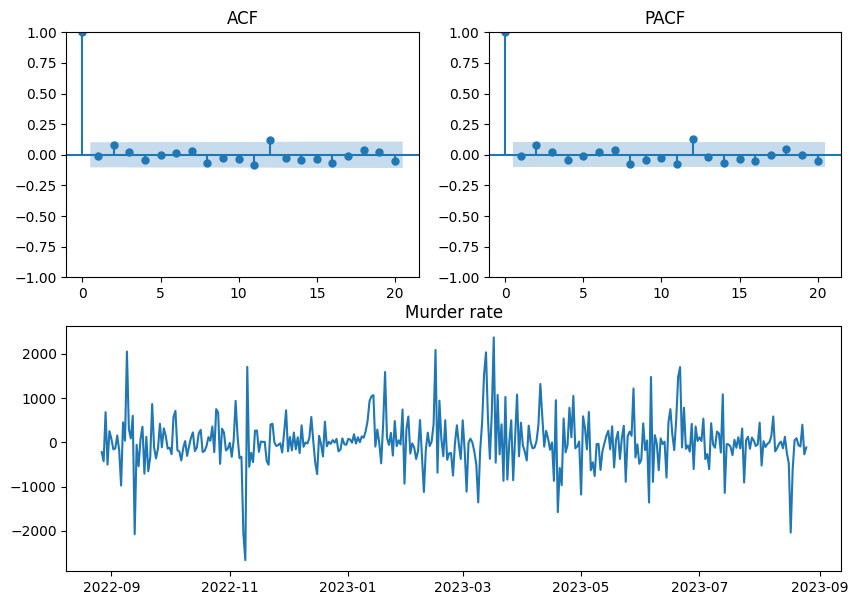

In [10]:
plt.figure(figsize=(10,7))
ax1 = plt.subplot(212)
ax1.plot(bitcoin_data_diff)
ax1.set_title('Murder rate')
ax2 = plt.subplot(221)
ax2=plot_acf(bitcoin_data_diff, lags=20, ax=plt.gca(), title='ACF')
ax3 = plt.subplot(222)
ax3=plot_pacf(bitcoin_data_diff, lags=20, ax=plt.gca(), title='PACF')

we again will perform KPSS test to the test statistic which is lower than 10% critical value and the p-value is high so we retain the $H_0$ and accept that data is staitionary.

In [11]:
kpss_test(bitcoin_data_diff)

Results of KPSS Test:
Test Statistic           0.093466
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


next, we want to do the ARIMA Model, and because there are no correlations between values using both ACF and PACF after first differencing choose P D Q as respectively 1,1,0 and build the model. and do a forecasting of 30 dates after today. we print the actual forecasted values here to see and also make a chart to visualize the forecasted values.

            predicted_mean
2023-08-26    26049.107265
2023-08-27    26049.089205
2023-08-28    26049.089432
2023-08-29    26049.089429
2023-08-30    26049.089429
2023-08-31    26049.089429
2023-09-01    26049.089429
2023-09-02    26049.089429
2023-09-03    26049.089429
2023-09-04    26049.089429
2023-09-05    26049.089429
2023-09-06    26049.089429
2023-09-07    26049.089429
2023-09-08    26049.089429
2023-09-09    26049.089429
2023-09-10    26049.089429
2023-09-11    26049.089429
2023-09-12    26049.089429
2023-09-13    26049.089429
2023-09-14    26049.089429
2023-09-15    26049.089429
2023-09-16    26049.089429
2023-09-17    26049.089429
2023-09-18    26049.089429
2023-09-19    26049.089429
2023-09-20    26049.089429
2023-09-21    26049.089429
2023-09-22    26049.089429
2023-09-23    26049.089429
2023-09-24    26049.089429


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


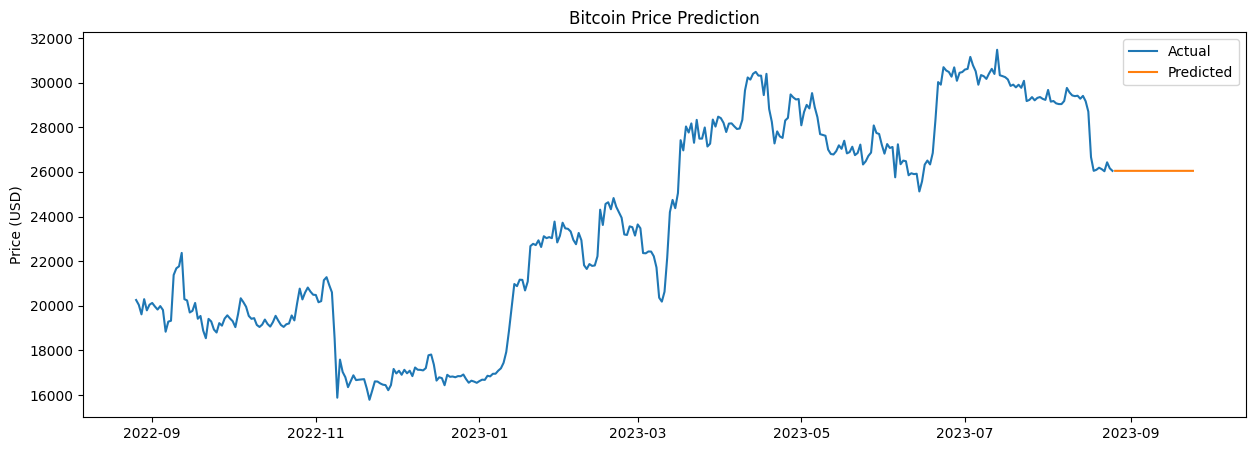

In [12]:

# Perform time series analysis using ARIMA model
model = ARIMA(bitcoin_data,
              order=(1, 1, 0))
model_fit = model.fit()

# Make future predictions
future_predictions = pd.DataFrame(model_fit.forecast(steps=30))
print(future_predictions)

# Plot the future predictions
plt.figure(figsize=(15,5))
plt.plot(bitcoin_data, label='Actual')
#plt.plot(model_fit.fittedvalues)
plt.plot(future_predictions, label='Predicted')
plt.title('Bitcoin Price Prediction')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

and for the model summary we have sigma 2 as the coefficient which is significant and the auto regression lag 1 which is not significant.

In [13]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  365
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2830.085
Date:                Sat, 26 Aug 2023   AIC                           5664.169
Time:                        11:48:27   BIC                           5671.964
Sample:                    08-26-2022   HQIC                          5667.267
                         - 08-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0125      0.035     -0.361      0.718      -0.081       0.056
sigma2      3.326e+05   1.52e+04     21.873      0.000    3.03e+05    3.62e+05
Ljung-Box (L1) (Q):                   0.02   Jarque-

the value of root mean squer error is also as follows:

In [14]:
print("RMSE for ARIMA Model: ", np.sqrt((model_fit.resid**2).mean()))

RMSE for ARIMA Model:  1206.3906516645177


Text(0.5, 1.0, '30 day pridictions')

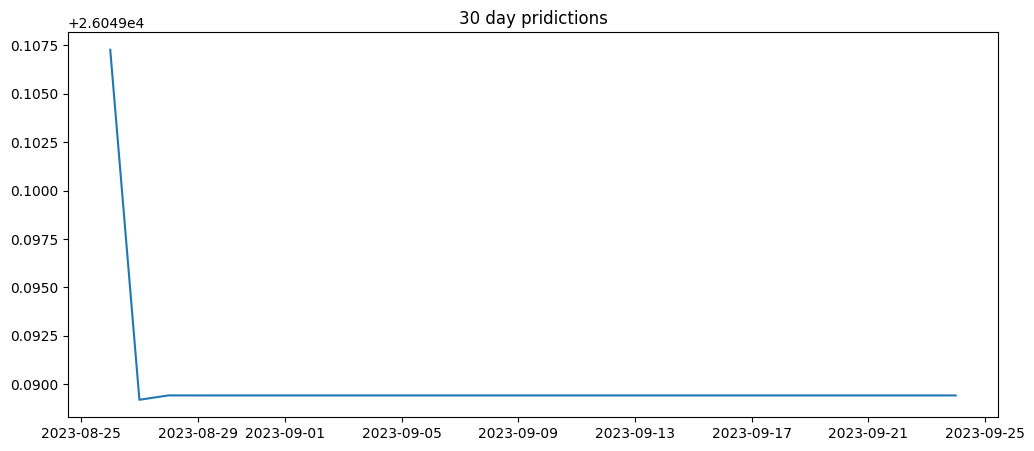

In [15]:
plt.figure(figsize=(12,5))
plt.plot(future_predictions)
plt.title('30 day pridictions')

now we want to check and see which model parameters does Auto Arima model from the package "pmdarima" chooses for an optimal model.

In [16]:

from pmdarima.arima import auto_arima

AAmodel=auto_arima(bitcoin_data,
                   start_P=0,
                   start_q=0,
                   max_d=2)
print(AAmodel.arparams)

<bound method ARIMA.arparams of ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>


The model auto arima chose is the order (0,1,0) which did not consider lag 1 autoregression as significant which was true and we can see the value of AIC is slightly lower than our model. The value of RMSE is also the same as our model.

In [17]:
print(AAmodel.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2830.120
Date:                Sat, 26 Aug 2023   AIC                           5662.239
Time:                        11:48:27   BIC                           5666.136
Sample:                    08-26-2022   HQIC                          5663.788
                         - 08-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.309e+05   1.41e+04     23.479      0.000    3.03e+05    3.58e+05
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               245.70
Prob(Q):                              0.89   Pr

In [18]:
print("RMSE for ARIMA Model: ", np.sqrt((AAmodel.resid()**2).mean()))

RMSE for ARIMA Model:  1206.4169127517307


## Test for Seasonality

We already know that our there is no seasonality in Bitcoin's price change in the past year but we are seeing a repetitive pattern in our data which brings us to the point that we wanted to try and see what is the pattern in our data. So we performed an exponential smoothing model using additive trend and seasonality and let the algorithm estimate the parameters, doing seasonal periods of less than 150 days. we stored the RMSE for each model for later comparison and see which seasonal period gives us the lowest RMSE in term of seasonality. and we plot and print the result to see the lowest value which is 116.

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL

rmse=[]
aic=[]
for k in range(3,150):
    modelexp=ExponentialSmoothing(bitcoin_data,
                              trend='add',
                              seasonal='add',
                              damped_trend=True,
                              initialization_method='estimated',
                              seasonal_periods=k).fit()

    rmse.append(np.sqrt((modelexp.resid**2).mean()))

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-pac

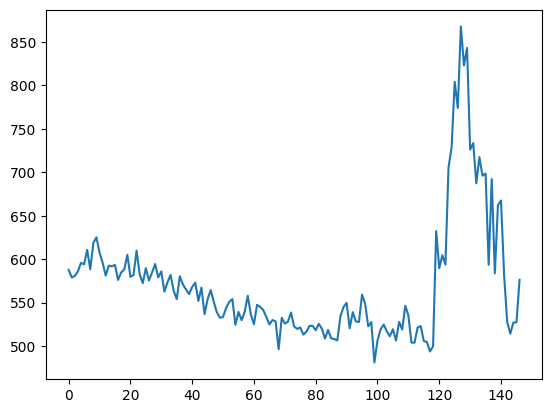

Optimal Seasonal Period:  99


In [20]:
plt.plot(rmse)
plt.show()
print('Optimal Seasonal Period: ',np.argmin(rmse))

We will run the STL model and plot the model to see the seasonality in the data, which we can see with a gradual decrease and increase in the variance there can be similarity in patterns each 116 days!

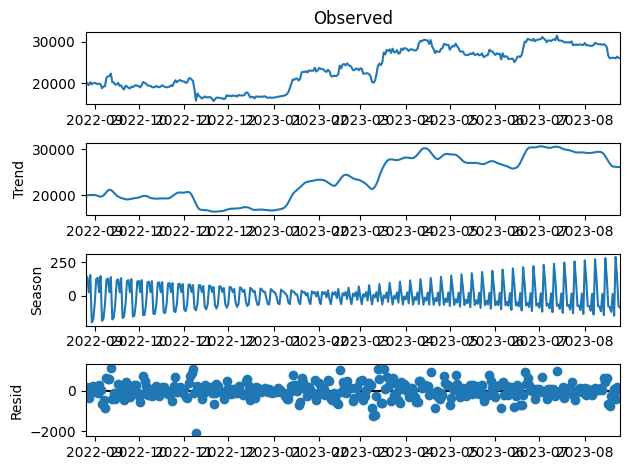

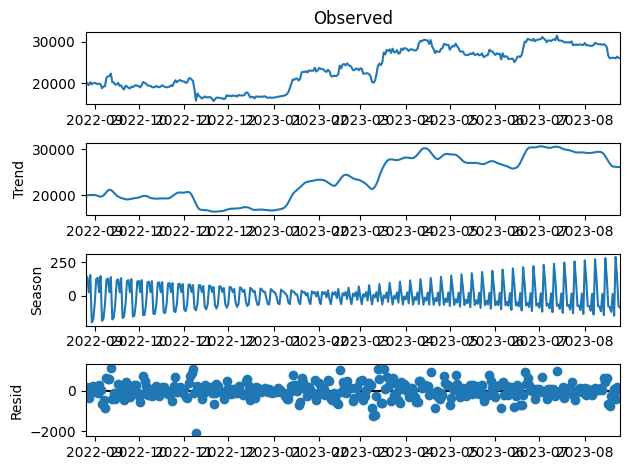

In [21]:
stl_model = STL(bitcoin_data,seasonal=115).fit()

stl_model.plot()

# Exponential Smoothing and Holt's Method:

after we understood that there is no seasonality and we have a trend we perform an exponential smoothing model with a damped trend and let the model decide the parameter values we forecast for the next 31 days which resulted in a downward trend which if we visually compare the trend with the past we can see a similar downward pattern in May 2023 up to July.

2023-08-26    26047.794742
2023-08-27    26047.348053
2023-08-28    26046.905830
2023-08-29    26046.468030
2023-08-30    26046.034608
2023-08-31    26045.605519
2023-09-01    26045.180722
2023-09-02    26044.760173
2023-09-03    26044.343829
2023-09-04    26043.931649
2023-09-05    26043.523590
2023-09-06    26043.119612
2023-09-07    26042.719674
2023-09-08    26042.323735
2023-09-09    26041.931755
2023-09-10    26041.543696
2023-09-11    26041.159517
2023-09-12    26040.779179
2023-09-13    26040.402646
2023-09-14    26040.029877
2023-09-15    26039.660836
2023-09-16    26039.295486
2023-09-17    26038.933789
2023-09-18    26038.575709
2023-09-19    26038.221210
2023-09-20    26037.870255
2023-09-21    26037.522811
2023-09-22    26037.178841
2023-09-23    26036.838310
2023-09-24    26036.501185
2023-09-25    26036.167431
Freq: D, dtype: float64


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


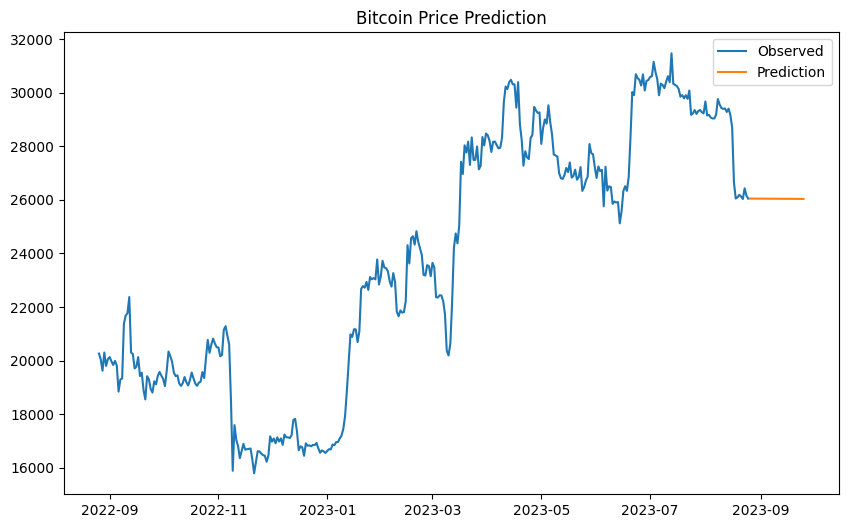

In [22]:
modelexp=ExponentialSmoothing(bitcoin_data,
                              trend='add',
                              damped_trend=True,
                              initialization_method='estimated').fit()

modelexp.summary()

expforecast=modelexp.forecast(steps=31)
print(expforecast)
plt.figure(figsize=(10,6))
plt.plot(bitcoin_data, label='Observed')
plt.plot(expforecast, label='Prediction')
plt.title('Bitcoin Price Prediction')
plt.legend()

the results for this model are very promising which we can see next when we calculated the RMSE for this model it is the best performance among all the models we already tried. and we also can see a significant drop in values of AIC, BIC and AICc.

In [23]:
print(modelexp.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  365
Model:             ExponentialSmoothing   SSE                      120822588.113
Optimized:                         True   AIC                           4649.127
Trend:                         Additive   BIC                           4668.626
Seasonal:                          None   AICC                          4649.441
Seasonal Periods:                  None   Date:                 Sat, 26 Aug 2023
Box-Cox:                          False   Time:                         11:48:38
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
smoothing_trend               0.00

In [24]:
print('RMSE for this model is: ', np.sqrt((modelexp.resid**2).mean()))

RMSE for this model is:  575.3440617141031


## Exponential Smoothing

we do this model once more using "heuristic" initialization method and smoothing level and smoothing trend values of 0.1 to get a smoother model fit to see the trend. As a remark we expect to see a possible higher RMSE because it is not the optimal model.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2023-08-26    26409.145813
2023-08-27    26251.288515
2023-08-28    26095.009790
2023-08-29    25940.293852
2023-08-30    25787.125074
2023-08-31    25635.487983
2023-09-01    25485.367263
2023-09-02    25336.747751
2023-09-03    25189.614433
2023-09-04    25043.952449
2023-09-05    24899.747084
2023-09-06    24756.983774
2023-09-07    24615.648096
2023-09-08    24475.725775
2023-09-09    24337.202677
2023-09-10    24200.064811
2023-09-11    24064.298323
2023-09-12    23929.889499
2023-09-13    23796.824764
2023-09-14    23665.090677
2023-09-15    23534.673930
2023-09-16    23405.561351
2023-09-17    23277.739897
2023-09-18    23151.196658
2023-09-19    23025.918852
2023-09-20    22901.893823
2023-09-21    22779.109045
2023-09-22    22657.552115
2023-09-23    22537.210754
2023-09-24    22418.072806
2023-09-25    22300.126238
Freq: D, dtype: float64
RMSE for this model is:  1304.5089222860697


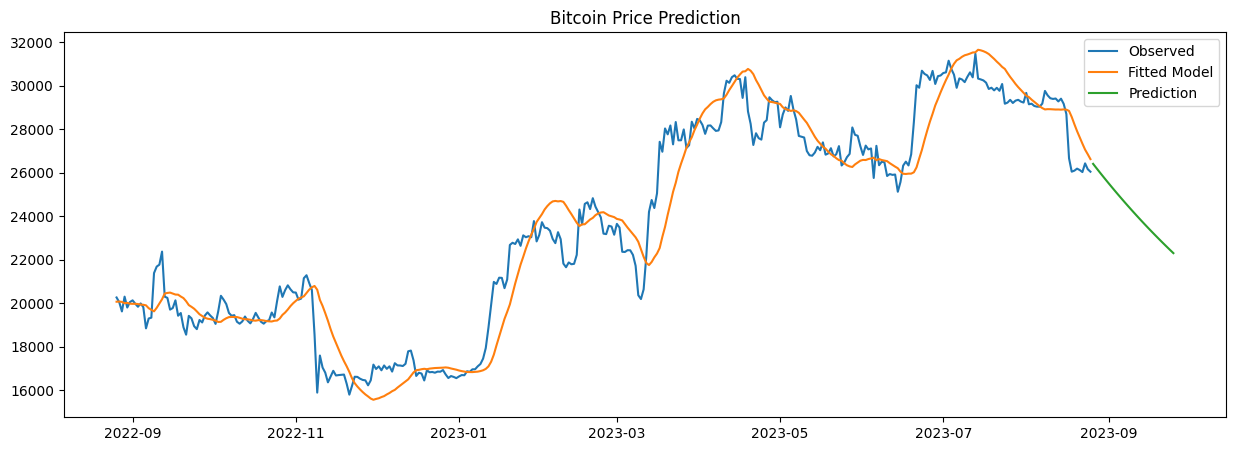

In [25]:
modelexp=ExponentialSmoothing(bitcoin_data,
                              trend='add',
                              damped_trend=True,
                              initialization_method='heuristic').fit(smoothing_level=0.1,
                                                                     smoothing_trend=0.1)

modelexp.summary()

expforecast=modelexp.forecast(steps=31)
print(expforecast)

plt.figure(figsize=(15,5))
plt.plot(bitcoin_data, label='Observed')
plt.plot(modelexp.fittedvalues, label='Fitted Model')
plt.plot(expforecast, label='Prediction')
plt.title('Bitcoin Price Prediction')
plt.legend()

print('RMSE for this model is: ', np.sqrt((modelexp.resid**2).mean()))

## Holt's Method
we performed 3 different methods the first one is Holt's linear method, the next one is the exponential method and last but not least Holt's damped trend model. we build all the models with smoothing level and smoothing trend values of 0.1 to compare them visually and using RMSE we can see that the lowest RMSE belongs to the damped trend.

RMSE linear model 1350.4800831257605
RMSE exponential model 1393.5855982578873
RMSE damped model 1304.5089222860697


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


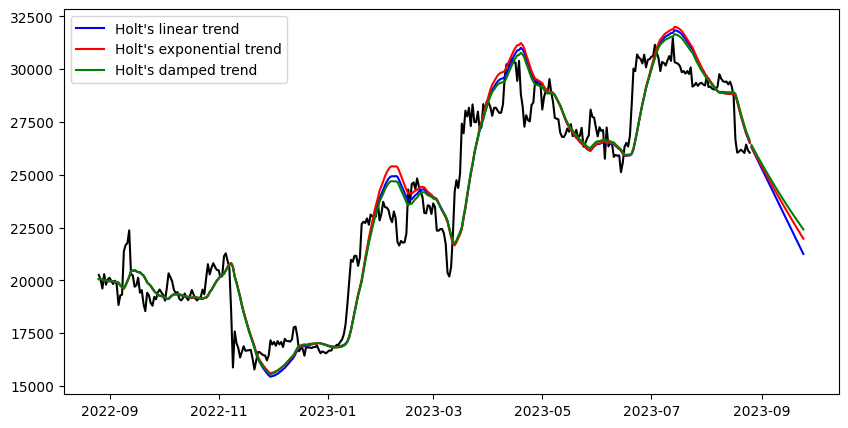

In [26]:
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
holt_1=Holt(bitcoin_data,
                     initialization_method='heuristic').fit(smoothing_level=0.1,
                                                            smoothing_trend=0.1,
optimized=False)
H_forecast1= holt_1.forecast(30).rename("Holt's linear trend")
holt_2=Holt(bitcoin_data, exponential=True,
                     initialization_method='heuristic').fit(smoothing_level=0.1,
                                                            smoothing_trend=0.1,
optimized=False)
H_forecast2= holt_2.forecast(30).rename("Holt's exponential trend")
holt_3=Holt(bitcoin_data, damped_trend=True,
                     initialization_method='heuristic').fit(smoothing_level=0.1,
                                                            smoothing_trend=0.1)
H_forecast3= holt_3.forecast(30).rename("Holt's damped trend")
plt.figure(figsize=(10,5))
plt.plot(bitcoin_data, color='black')
plt.plot(holt_1.fittedvalues, color='blue')
(line1,) = plt.plot(H_forecast1,color='blue')
plt.plot(holt_2.fittedvalues, color='red')
(line2,) = plt.plot(H_forecast2,color='red')
plt.plot(holt_3.fittedvalues, color='green')
(line3,) = plt.plot(H_forecast3,color='green')
plt.legend([line1,line2,line3],[H_forecast1.name,H_forecast2.name,H_forecast3.name])
print('RMSE linear model',np.sqrt(((holt_1.resid)**2). mean()))
print('RMSE exponential model',np.sqrt(((holt_2. resid)**2).mean()))
print('RMSE damped model',np.sqrt(((holt_3.resid)**2). mean()))

## ETS Model

Lastly, we will try an ETS model with an additive damped trend and let the algorithm estimate the parameters 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  8.56698D+00    |proj g|=  8.99900D-01

At iterate    1    f=  7.77885D+00    |proj g|=  1.03597D-01

At iterate    2    f=  7.77505D+00    |proj g|=  6.17639D-02

At iterate    3    f=  7.77323D+00    |proj g|=  8.25047D-03

At iterate    4    f=  7.77318D+00    |proj g|=  7.13323D-03

At iterate    5    f=  7.77306D+00    |proj g|=  1.13545D-03

At iterate    6    f=  7.77306D+00    |proj g|=  1.24611D-04

At iterate    7    f=  7.77306D+00    |proj g|=  1.59859D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


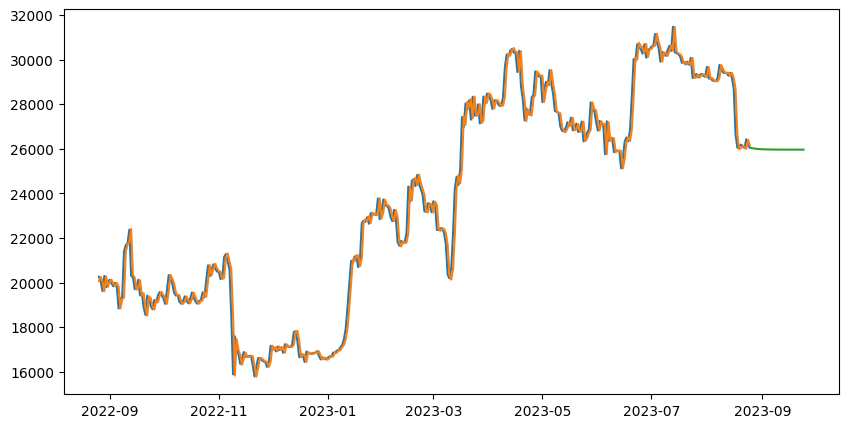

In [27]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

ets = ETSModel(bitcoin_data['Price'],
               trend='add',
               damped_trend=True,
               initialization_method='estimated').fit()

ets_pred=ets.forecast(30)
plt.figure(figsize=(10,5))
plt.plot(bitcoin_data)
plt.plot(ets.fittedvalues)
plt.plot(ets_pred)

ETS model performed the best among all the models considering RMSE which we can see in the last code chunk, and from the chart we saw earlier predicts the price to continue the downward trend and settles around the value of 25500 in the next 30 days.

In [28]:
print(ets_pred)


2023-08-26    26033.891715
2023-08-27    26019.746497
2023-08-28    26008.430323
2023-08-29    25999.377383
2023-08-30    25992.135032
2023-08-31    25986.341151
2023-09-01    25981.706046
2023-09-02    25977.997962
2023-09-03    25975.031495
2023-09-04    25972.658321
2023-09-05    25970.759782
2023-09-06    25969.240951
2023-09-07    25968.025886
2023-09-08    25967.053834
2023-09-09    25966.276192
2023-09-10    25965.654079
2023-09-11    25965.156389
2023-09-12    25964.758236
2023-09-13    25964.439714
2023-09-14    25964.184896
2023-09-15    25963.981042
2023-09-16    25963.817959
2023-09-17    25963.687493
2023-09-18    25963.583119
2023-09-19    25963.499621
2023-09-20    25963.432822
2023-09-21    25963.379383
2023-09-22    25963.336631
2023-09-23    25963.302430
2023-09-24    25963.275069
Freq: D, Name: simulation, dtype: float64


In [29]:

print(ets.summary())

                                 ETS Results                                  
Dep. Variable:                  Price   No. Observations:                  365
Model:                      ETS(AAdN)   Log Likelihood               -2837.168
Date:                Sat, 26 Aug 2023   AIC                           5686.336
Time:                        11:48:38   BIC                           5709.735
Sample:                    08-26-2022   HQIC                          5695.635
                         - 08-25-2023   Scale                       330462.695
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9631        nan        nan        nan         nan         nan
smoothing_trend     0.0421        nan        nan        nan         nan         nan
damping_trend       0.8000      

In [30]:
print("RMSE for ETS Model: ", np.sqrt((ets.resid**2).mean()))

RMSE for ETS Model:  574.8588479965083


# Conclusion 

We saw that the ETS model performed best considering RMSE and predicted a more constant trend in the next 30 days but the first exponential smoothing method that we did we received a slightly higher RMSE from the model but the values of AIC, BIC and AICc were very lower than ETS model. then we choose the best model to be an exponential smoothing or Holt's damped trend model.